# Statistical Tests

## Import libraries

In [1]:
#!pip install seaborn

In [2]:
#!pip install matplotlib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.stats.power import tt_ind_solve_power
#from scipy.stats import mannwhitneyu
#from scipy.stats import ttest_ind
#from scipy.stats import median_test

from tqdm import tqdm

## Importing data

In [4]:
df = pd.read_csv('bootstrap_homework.csv')

In [5]:
df.sample(5)

,passport_id,region,revenue,group
31069,134226089,Новосибирск,288,1
15572,140932813,Новосибирск,330,0
29097,140693771,Новосибирск,450,0
11052,140726377,Новосибирск,580,1
6745,138800504,Новосибирск,640,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32115 entries, 0 to 32114
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   passport_id  32115 non-null  int64 
 1   region       32115 non-null  object
 2   revenue      32115 non-null  int64 
 3   group        32115 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1003.7+ KB


In [7]:
df.isna().sum()

passport_id    0
region         0
revenue        0
group          0
dtype: int64

In [8]:
df.passport_id.nunique()

32115

In [9]:
df.group.value_counts()

1    16121
0    15994
Name: group, dtype: int64

In [10]:
df.group.value_counts(normalize=True)

1    0.501977
0    0.498023
Name: group, dtype: float64

In [11]:
df.revenue.describe()

count     32115.000000
mean       1561.262463
std        7687.990519
min         135.000000
25%         297.000000
50%         480.000000
75%        1332.000000
max      751925.000000
Name: revenue, dtype: float64

## Tasks

### Task 1.

 **Find the 0.7 quantile of the revenue distribution for group 0.**

In [12]:
np.quantile(df[df['group'] == 0].revenue, q=.7)

960.0

### Task 2.  

**Find the 0.7 quantile of the revenue distribution for group 1.**

In [13]:
np.quantile(df[df['group'] == 1].revenue, q=.7)

1128.0

### Task 3.

**Find IQR for group 0.**

In [14]:
def iqr(df, col):
    """Calculates the interquartile range (IQR) of a given column in a pandas DataFrame.
    Args:
        df (pandas.DataFrame): The pandas DataFrame.
        col (str): The column name.
    Returns:
        float: The interquartile range.
    """

    # Get the data for the given column.
    data = df[col]

    # Calculate the first and third quartiles.
    q1 = np.quantile(data, q=.25)
    q3 = np.quantile(data, q=.75)

    # Calculate the IQR.
    iqr = q3 - q1

    # Return the IQR.
    return iqr

In [15]:
iqr(df[df['group'] == 0], 'revenue')

963.0

### Task 4. 

**Find IQR for group 1.**

In [16]:
iqr(df[df['group'] == 1], 'revenue')

1186.0

### Task 5. 

**Use bootstrap to test the hypothesis of equality of the 0.8 quantile of distributions between two groups. Alpha = 0.05. Before starting the first bootstrap iteration, set np.random.seed(1). Number of bootstrap iterations = 10,000. Is the H0 hypothesis of equality of quantiles rejected?**

In [17]:
def bootstrap_ab_test(sample_data_A, sample_data_B, stat, resample_num, alpha, q, seed):
    '''
    sample_data_A - values in sample A
    sample_data_B - values in sample B
    stat - can pass an estimator function
    resample_num - number of iterations of resample sample extraction in bootstrap
    alpha - significance level for the test
    q - is specified if you are estimating a specific distribution quantile
    seed - random seed value
    '''
    # A function to return resample samples resample_num times
    def get_resampled_data(sample, sample_size, resample_num):
        resampled_data = np.random.choice(sample, size = (resample_num, sample_size), replace=True)
        return(resampled_data)
    
    # A function to extract the given statistic from the obtained samples
    def get_resampled_stats(resampled_data, stat):
        resampled_stats = stat(resampled_data, axis = 1)
        return(resampled_stats)
    
    # A function to extract quantiles from resample samples
    def get_resampled_quantile(resampled_data, q=0.5):
        resampled_stats = np.quantile(resampled_data, q=q, axis = 1)
        return(resampled_stats)
    
    # Get bootstrapped data
    if seed:
        np.random.seed(seed)
    resampled_data_A = get_resampled_data(sample_data_A, len(sample_data_A), resample_num)
    resampled_data_B = get_resampled_data(sample_data_B, len(sample_data_B), resample_num)

    if q is not None:
        resampled_stats_A = get_resampled_quantile(resampled_data_A, q)
        resampled_stats_B = get_resampled_quantile(resampled_data_B, q)
    else:
        resampled_stats_A = get_resampled_stats(resampled_data_A, stat)
        resampled_stats_B = get_resampled_stats(resampled_data_B, stat)

    # Calculate the difference for the statistic
    resampled_diffs = resampled_stats_B - resampled_stats_A

    # Calculate the percentile bootstrap
    perc_ci = np.quantile(resampled_diffs, [alpha/2, 1-alpha/2])

    if q is not None:
        samples_diff = np.quantile(sample_data_B, q) - np.quantile(sample_data_A, q)
    else:
        samples_diff = stat(sample_data_B) - stat(sample_data_A)

    # Calculating p-value
    adjusted_resampled_diffs = resampled_diffs - samples_diff
    false_positive_count = np.sum(np.abs(adjusted_resampled_diffs) >= np.abs(samples_diff))
    p_value = false_positive_count / resample_num

    # Returning results
    boot_data_object = {'resample_stats_A':resampled_stats_A,
                         'resample_stats_B':resampled_stats_B,
                         'resampled_diffs': resampled_diffs,
                         'conf_int': perc_ci,
                         'stat_diffs_std': resampled_diffs.std(),
                         'p_value': p_value}
    return(boot_data_object)

In [18]:
alpha = 0.05
boot_iters = 10000
quantile = 0.8
seed = 1

control_data = df[df['group'] == 0].revenue
test_data = df[df['group'] == 1].revenue


boot_res = bootstrap_ab_test(sample_data_A = control_data,
    sample_data_B = test_data,
    stat = np.mean,
    resample_num = boot_iters,
    alpha = alpha,
    q = quantile,
    seed = 1)

In [19]:
pval = boot_res['p_value']

if pval < alpha:
    print(f'p-value: {pval:.4f} --> We can reject the H0!!!')
else:
    print(f'p-value: {pval:.4f} --> We are not able to reject the H0.')

p-value: 0.1804 --> We are not able to reject the H0.


### Task 6. 

**Use bootstrap to test the hypothesis of equality of the 0.4 quantile of distributions between two groups. Alpha = 0.05. Before starting the first bootstrap iteration, set np.random.seed(1). Number of bootstrap iterations = 10,000. Is the H0 hypothesis of equality of quantiles rejected?**

In [20]:
alpha = 0.05
boot_iters = 10000
quantile = 0.4
seed = 1

control_data = df[df['group'] == 0].revenue
test_data = df[df['group'] == 1].revenue


boot_res = bootstrap_ab_test(sample_data_A = control_data,
    sample_data_B = test_data,
    stat = np.mean,
    resample_num = boot_iters,
    alpha = alpha,
    q = quantile,
    seed = 1)

In [21]:
pval = boot_res['p_value']

if pval < alpha:
    print(f'p-value: {pval:.4f} --> We can reject the H0!!!')
else:
    print(f'p-value: {pval:.4f} --> We are not able to reject the H0.')

p-value: 0.0000 --> We can reject the H0!!!


### Task 7. 

**Specify the average difference in quantiles obtained using bootstrap on the previous step..**

In [22]:
boot_res['resampled_diffs'].mean()

-56.111380000000075

### Task 8. 

**Use bootstrap to test the hypothesis of equality of the 0.65 quantile of distributions between two groups. Alpha = 0.05. Before starting the first bootstrap iteration, set np.random.seed(1). Number of bootstrap iterations = 10,000. Is the H0 hypothesis of equality of quantiles rejected?**

In [23]:
alpha = 0.05
boot_iters = 10000
quantile = 0.65
seed = 1

control_data = df[df['group'] == 0].revenue
test_data = df[df['group'] == 1].revenue


boot_res = bootstrap_ab_test(sample_data_A = control_data,
    sample_data_B = test_data,
    stat = np.mean,
    resample_num = boot_iters,
    alpha = alpha,
    q = quantile,
    seed = 1)

In [24]:
pval = boot_res['p_value']

if pval < alpha:
    print(f'p-value: {pval:.4f} --> We can reject the H0!!!')
else:
    print(f'p-value: {pval:.4f} --> We are not able to reject the H0.')

p-value: 0.0000 --> We can reject the H0!!!


### Task 9. 

**Let's conduct a decile analysis, i.e., let's look for effects in the entire space of deciles of the distribution.  
Determine using bootstrap from which percentile of the distribution the effect on revenue begins to be detected.  
Start simulations from the 0.01 percentile.  
The step of percentiles search in the simulations is 0.01.  
Before starting the search, set np.random.seed(1).  
For each iteration of the search, use the following bootstrap configuration:  
alpha = 0.05  
number of iterations inside the bootstrap = 2000  
multiple comparisons correction - Bonferroni.**

In [25]:
# Let's plot a graph of p-values obtained through bootstrap 
# to test the hypothesis of equality of percentiles for each percentile
peek_num = 99  # number of observation points in the linear space of percentiles. Number of hypotheses to be tested in the percentile space
perc_linspace = np.linspace(0.01, 1, peek_num)
boot_iters = 2000

p_val_list = []
diffs_list = []
lower_ci_list = []
upper_ci_list = []

# for each defined percentile, we test the hypothesis of equality of percentiles using bootstrap
for i in tqdm(perc_linspace):
    boot_data = bootstrap_ab_test(sample_data_A = control_data,
                  sample_data_B = test_data,
                  stat = np.mean,
                  resample_num = boot_iters,
                  alpha = (0.05/peek_num), q = i, seed = 1)  # applying Bonferroni correction
    p_val_list.append(boot_data['p_value'])
    diffs_list.append(boot_data['resampled_diffs'].mean())
    lower_ci_list.append(boot_data['conf_int'][0])
    upper_ci_list.append(boot_data['conf_int'][1])
p_val_list = np.array(p_val_list)
diffs_list = np.array(diffs_list)
lower_ci_list = np.array(lower_ci_list)
upper_ci_list = np.array(upper_ci_list)

100%|██████████| 99/99 [05:43<00:00,  3.47s/it]


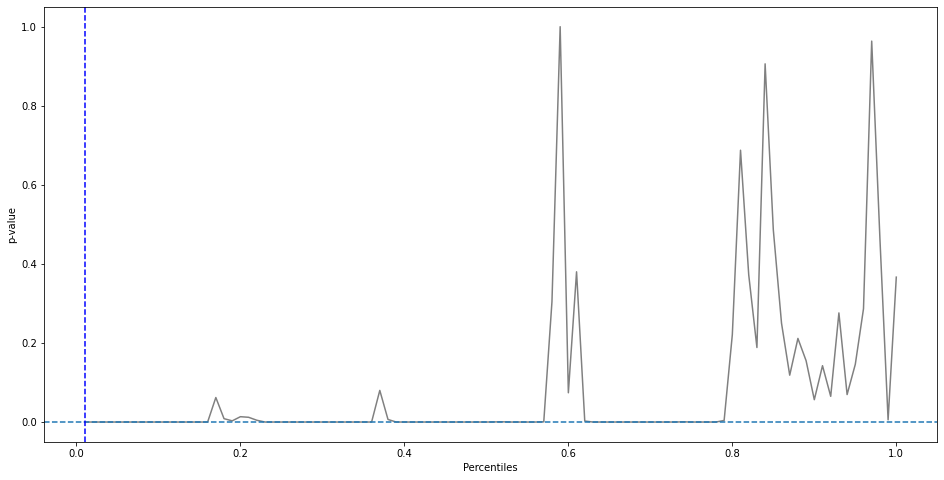

In [26]:
# let's have a look on the result we have
plt.figure(figsize=(16,8))

sns.lineplot(x = np.round(perc_linspace,2), y = p_val_list, color= 'gray')

plt.xlabel('Percentiles')
plt.ylabel('p-value')
plt.axhline(y = (0.05/peek_num), linestyle = '--')
plt.axvline(perc_linspace[p_val_list <= (0.05/peek_num)].min(), linestyle = '--', color = 'blue');

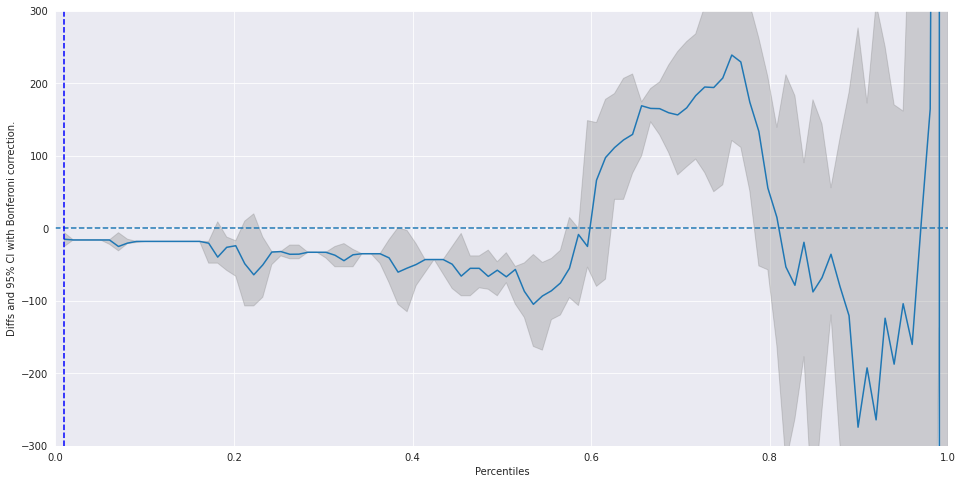

In [27]:
# another way to visualize the obtained results
plt.figure(figsize=(16,8))

sns.set_style('darkgrid')
sns.lineplot(x = perc_linspace, y = diffs_list, err_style='band')

plt.ylim(-300,300)
plt.xlim(0, 1)
plt.axhline(y = 0, linestyle = '--')
plt.axvline(perc_linspace[p_val_list <= (0.05/peek_num)].min(), linestyle = '--', color = 'blue')
plt.fill_between(perc_linspace, lower_ci_list, upper_ci_list, color = 'grey', alpha=0.3)
plt.xlabel('Percentiles')
plt.ylabel('Diffs and 95% CI with Bonferoni correction.');

### Task 10. 

**What is the absolute observed effect found when bootstrapped on this percentile from the simulation performed above?.**

In [28]:
alpha = 0.05
boot_iters = 10000
quantile = 0.01
seed = 1

control_data = df[df['group'] == 0].revenue
test_data = df[df['group'] == 1].revenue


boot_res = bootstrap_ab_test(sample_data_A = control_data,
    sample_data_B = test_data,
    stat = np.mean,
    resample_num = boot_iters,
    alpha = alpha,
    q = quantile,
    seed = 1)

In [29]:
boot_res['resampled_diffs'].mean()

-15.0122

### Task 11. 

**From what percentile do we first start to catch a positive effect between quantiles (quantile group 1 > quantile group 0)?**

In [30]:
for i in range(len(diffs_list)):
    if diffs_list[i] <= 0:
        pass
    else:
        print(f'quantile: {(i+1) / 100}')
        break

quantile: 0.6


### Task 12. 

**What is the absolute observed effect found when bootstrapped on the percentile from the simulation conducted in the previous task?**

In [31]:
print(f'Absolute observed effect for {(i+1) / 100} quantile: {diffs_list[i]}')

Absolute observed effect for 0.6 quantile: 66.3920448979591
